# Create Submission File for Kaggle

### Load Test Data

In [298]:
from src.data.datasets.data_loader import get_loader
import numpy as np

loader = get_loader(data_source_name="kaggle_brisT1D", dataset_type="test", use_cached=True)
data = loader.processed_data

In [299]:
PATIENT = "p04"

data[PATIENT].keys()

dict_keys(['p04_24828', 'p04_24830', 'p04_24698', 'p04_24695', 'p04_24912', 'p04_24804', 'p04_24894', 'p04_24719', 'p04_24904', 'p04_24756', 'p04_24690', 'p04_24936', 'p04_24811', 'p04_24943', 'p04_24766', 'p04_24687', 'p04_24903', 'p04_24807', 'p04_24700', 'p04_24937', 'p04_24882', 'p04_24930', 'p04_24919', 'p04_24800', 'p04_24823', 'p04_24709', 'p04_24854', 'p04_24707', 'p04_24924', 'p04_24688', 'p04_24742', 'p04_24841', 'p04_24727', 'p04_24773', 'p04_24781', 'p04_24836', 'p04_24884', 'p04_24692', 'p04_24741', 'p04_24929', 'p04_24910', 'p04_24892', 'p04_24798', 'p04_24779', 'p04_24938', 'p04_24787', 'p04_24721', 'p04_24874', 'p04_24783', 'p04_24713', 'p04_24745', 'p04_24849', 'p04_24900', 'p04_24763', 'p04_24758', 'p04_24935', 'p04_24844', 'p04_24859', 'p04_24806', 'p04_24931', 'p04_24748', 'p04_24702', 'p04_24839', 'p04_24789', 'p04_24809', 'p04_24939', 'p04_24864', 'p04_24792', 'p04_24740', 'p04_24832', 'p04_24911', 'p04_24808', 'p04_24906', 'p04_24760', 'p04_24693', 'p04_24887', '

In [300]:
len(data[PATIENT].keys())

258

In [421]:
row1 = data[PATIENT]['p04_24828']

In [404]:
# Split up data into day and night
loader = get_loader(dataset_type="train", use_cached=True)

train_df = loader.train_data[loader.train_data["p_num"] == PATIENT]
test_df = loader.validation_data[loader.validation_data["p_num"] == PATIENT]

In [405]:
# import pandas as pd
from src.tuning.benchmark import impute_missing_values


def reduce_features(df):
    # Make sure index is set to datetime
    p_df = df.iloc[:]
    # p_df.set_index("datetime", inplace=True)
    # p_df = p_df.asfreq('5T', method='pad')

    # Reduce features
    y_feature = ["bg-0:00"]
    x_features = [
        # "hr-0:00",
        "steps-0:00",
        # "cals-0:00",
        "cob",
        "carb_availability",
        "insulin_availability",
        "iob",
    ]
    p_df = p_df[x_features + y_feature]

    # Impute with default methods
    p_df = impute_missing_values(p_df, columns=x_features)
    p_df = impute_missing_values(p_df, columns=y_feature)

    y, X = p_df[y_feature], p_df[x_features]
    return y, X

In [457]:
y_test, X_test = reduce_features(row1)

In [423]:
y_test

,bg-0:00
0,6.5
1,6.5
2,6.5
3,6.5
4,5.9
...,...
67,7.7
68,7.8
69,8.8
70,10.2


In [424]:
X_test

,steps-0:00,cob,carb_availability,insulin_availability,iob
0,0.0,0.0,0.0,0.000000,0.070800
1,0.0,0.0,0.0,0.000125,0.141588
2,0.0,0.0,0.0,0.000689,0.212178
3,0.0,0.0,0.0,0.001786,0.282233
4,0.0,0.0,0.0,0.003400,0.343886
...,...,...,...,...,...
67,0.0,0.0,0.0,0.095215,1.618535
68,0.0,0.0,0.0,0.096439,1.589957
69,0.0,0.0,0.0,0.096988,1.579733
70,0.0,0.0,0.0,0.097080,2.329071


In [353]:
y_train, X_train = reduce_features(train_df)

In [355]:
import pandas as pd
from sktime.forecasting.base import ForecastingHorizon

TIME_STEP_SIZE = (
    pd.to_datetime(row1["datetime"]).iloc[1] - pd.to_datetime(row1["datetime"]).iloc[0]
).components.minutes

if TIME_STEP_SIZE != 5 and TIME_STEP_SIZE != 15:
    error = """
    First time step is not 5 or 15 minutes. Look at the most common time step size.
    """

HOURS_TO_PREDICT = 6
NUM_STEPS = HOURS_TO_PREDICT * 60 // TIME_STEP_SIZE

fh = np.arange(1, NUM_STEPS + 1)
fh


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72])

## Tiny Time Mixer Forecast

In [356]:
from sktime.forecasting.ttm import TinyTimeMixerForecaster
import numpy as np
import pandas as pd

# loss_callback = LossPlottingCallback()

current_time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

training_samples = len(y_train)

BATCH_SIZE = 128
STEPS_PER_EPOCH = training_samples // BATCH_SIZE
NUM_TRAIN_EPOCH = 5000  # How many epochs to run
SAVE_EVERY_EPOCH = 100  # How many epochs to save
model = "TinyTimeMixer"


interval = "05mins" if TIME_STEP_SIZE == 5 else "15mins"
dir_path = f"../../src/models/ttm/{interval}/{PATIENT}/{current_time}"

ttm_forecaster = TinyTimeMixerForecaster(
    config={
        "context_length": (60 // TIME_STEP_SIZE) * 18,  # 18 hours of context length
        "prediction_length": (60 // TIME_STEP_SIZE) * 6,  # 6 hours of prediction length
    },
    training_args={
        "num_train_epochs": NUM_TRAIN_EPOCH,
        "output_dir": dir_path,
        "use_cpu": False,
        "per_device_train_batch_size": BATCH_SIZE,
        "save_steps": STEPS_PER_EPOCH * SAVE_EVERY_EPOCH,
        # "callbacks": [],  # Add the callback here, why is this not working?
    },
)

print("selected interval: ", interval)
print(f"Training samples: {training_samples}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Every epoch has: {STEPS_PER_EPOCH} batches (or steps)")
print(f"Saving a checkpoint every {STEPS_PER_EPOCH * SAVE_EVERY_EPOCH} steps")

selected interval:  05mins
Training samples: 19018
Batch size: 128
Every epoch has: 148 batches (or steps)
Saving a checkpoint every 14800 steps


In [357]:
# ttm_forecaster.fit(y=y_train, X=X_train, fh=fh)

In [ ]:
import os 

# 6 hr fh model
model_path = "../../src/models/ttm/05mins/p04/2025-07-11_09-53-46"

patient = "p04"

checkpoint_dirs = []

dirs = [d for d in os.listdir(model_path) if os.path.isdir(os.path.join(model_path, d))]

for dir in dirs:
    if dir.startswith("checkpoint-"):
        checkpoint_dirs.append(model_path + "/" + dir)

# Sort checkpoints by number
checkpoint_dirs = sorted(checkpoint_dirs, key=lambda x: int(x.split("-")[-1]))
model_path = checkpoint_dirs[-1]
print(len(checkpoint_dirs))
print("model_path", model_path)

# This is the model we are using
ttm_checkpoint = TinyTimeMixerForecaster(model_path=model_path)
training_samples = len(y_train)
batch_size = 128
steps_per_epoch = training_samples // batch_size
# Extract checkpoint number from model path
checkpoint_num = int(model_path.split("-")[-1])
print(f"Using checkpoint {checkpoint_num}")
epoch_num = round(checkpoint_num / (steps_per_epoch * SAVE_EVERY_EPOCH))
print(f"Epoch number: {epoch_num}")


ttm_forecaster = TinyTimeMixerForecaster(
        model_path=model_path
    )
ttm_forecaster.fit(y=y_train, X=X_train, fh=fh)


40
model_path ../../src/models/ttm/05mins/p04/2025-07-11_09-53-46/checkpoint-585000
Using checkpoint 585000
Epoch number: 40


TinyTimeMixerForecaster(model_path='../../src/models/ttm/05mins/p04/2025-07-11_09-53-46/checkpoint-585000')

In [389]:
gen = loader.get_validation_day_splits(patient)
_, train_period, test_period = next(gen)
_, train_period, test_period = next(gen)
y_day, X_day = reduce_features(train_period)
# y_night, X_night = reduce_features(test_period)
y_day.index = y_day.index - 80852
X_day.index = X_day.index - 80852
# y_night.index = y_night.index - 80852
# X_night.index = X_night.index - 80852
y_day_72 = y_day[:72]
y_day_72


,bg-0:00
0,9.0
1,9.0
2,8.9
3,8.9
4,9.0
...,...
67,8.7
68,9.4
69,10.7
70,10.7


In [390]:
X_day_72= X_day[:72]
X_day_72

,steps-0:00,cob,carb_availability,insulin_availability,iob
0,0.0,0.000000,0.000000,0.785560,14.710512
1,0.0,0.000000,0.000000,0.791223,14.584194
2,0.0,0.000000,0.000000,0.796764,14.347570
3,0.0,0.000000,0.000000,0.796087,13.995448
4,0.0,0.000000,0.000000,0.793655,13.652081
...,...,...,...,...,...
67,22.0,119.278010,61.385753,2.079737,39.628889
68,65.0,111.634907,60.626289,1.855078,35.672886
69,12.0,117.723019,59.179546,1.916825,34.797643
70,38.0,110.369887,58.480231,1.958402,37.372742


In [391]:

# Update the model with the true glucose levels for the day
ttm_forecaster.update(y=y_day_72, X=X_day_72, update_params=False)

######## Determine MSE between predicted and true glucose levels ########
predicted_bg = ttm_forecaster.predict(fh=fh)
predicted_bg

,bg-0:00
72,5.872080
73,5.789082
74,5.714462
75,5.649093
76,5.581665
...,...
139,6.627709
140,6.616178
141,6.602843
142,6.580472


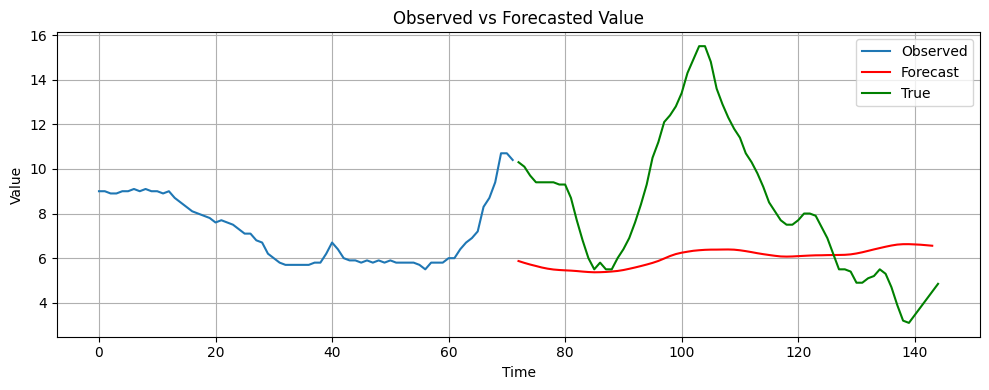

In [392]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_day_72, label='Observed', linestyle="-")
plt.plot(predicted_bg, label='Forecast', linestyle="-", color='red')
plt.plot(y_day[72:72+NUM_STEPS+1], label='True', linestyle="-", color='green')

plt.title("Observed vs Forecasted Value")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# this is the model that was trained with 1 hour fh
# model_path = "../../src/models/ttm/05mins/p04/2025-07-11_00-24-55/checkpoint-585000"
ttm_forecaster = TinyTimeMixerForecaster(
        model_path=model_path
    )

HOURS_TO_PREDICT = 1
NUM_STEPS = HOURS_TO_PREDICT * 60 // TIME_STEP_SIZE

fh = np.arange(1, NUM_STEPS + 1)

ttm_forecaster.fit(y=y_train, X=X_train, fh=fh)


ttm_forecaster = TinyTimeMixerForecaster(
        model_path=model_path
    )
ttm_forecaster.fit(y=y_train, X=X_train, fh=fh)


TinyTimeMixerForecaster(model_path='../../src/models/ttm/05mins/p04/2025-07-11_00-24-55/checkpoint-585000')

In [464]:
y_test, X_test = reduce_features(row1)

In [465]:
X_test.index = X_test.index + 80852
y_test.index = y_test.index + 80852

In [466]:
y_test

,bg-0:00
80852,6.5
80853,6.5
80854,6.5
80855,6.5
80856,5.9
...,...
80919,7.7
80920,7.8
80921,8.8
80922,10.2


In [467]:
X_test

,steps-0:00,cob,carb_availability,insulin_availability,iob
80852,0.0,0.0,0.0,0.000000,0.070800
80853,0.0,0.0,0.0,0.000125,0.141588
80854,0.0,0.0,0.0,0.000689,0.212178
80855,0.0,0.0,0.0,0.001786,0.282233
80856,0.0,0.0,0.0,0.003400,0.343886
...,...,...,...,...,...
80919,0.0,0.0,0.0,0.095215,1.618535
80920,0.0,0.0,0.0,0.096439,1.589957
80921,0.0,0.0,0.0,0.096988,1.579733
80922,0.0,0.0,0.0,0.097080,2.329071


In [468]:

ttm_forecaster.update(y=y_test, X=X_test, update_params=False)

y_pred_ttm = ttm_forecaster.predict(fh=fh) 
y_pred_ttm

,bg-0:00
80924,11.290987
80925,11.546245
80926,11.650707
80927,11.638237
80928,11.533509
80929,11.351678
80930,11.109256
80931,10.821302
80932,10.521155
80933,10.198523


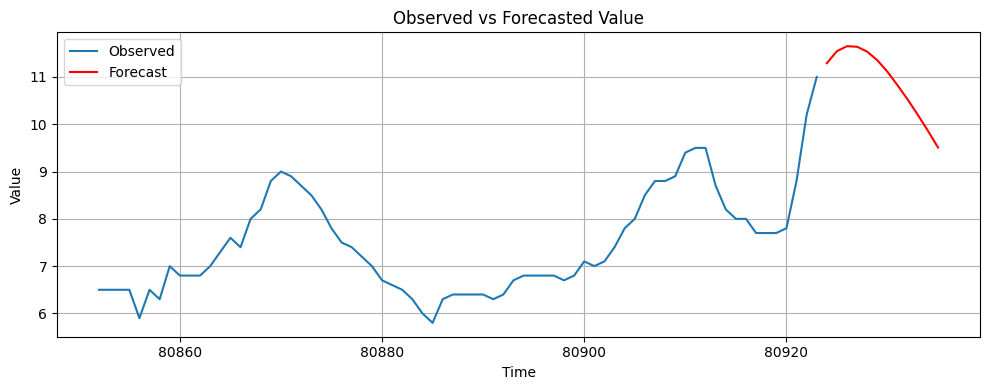

In [469]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Observed', linestyle="-")
plt.plot(y_pred_ttm, label='Forecast', linestyle="-", color='red')
plt.title("Observed vs Forecasted Value")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### NaiveForecaster

In [470]:
from src.tuning.load_estimators import load_all_forecasters, get_estimator

# This loads all sktime forecasters to be accessible by their class name -> don't need to run again
forecasters = load_all_forecasters()

forecaster_class = get_estimator(forecasters, "NaiveForecaster")
naive_forecaster = forecaster_class(strategy="last")
naive_forecaster.fit(y=y_test, X=X_test, fh=fh)

NaiveForecaster()

In [471]:
y_pred_naive = naive_forecaster.predict(fh=fh)

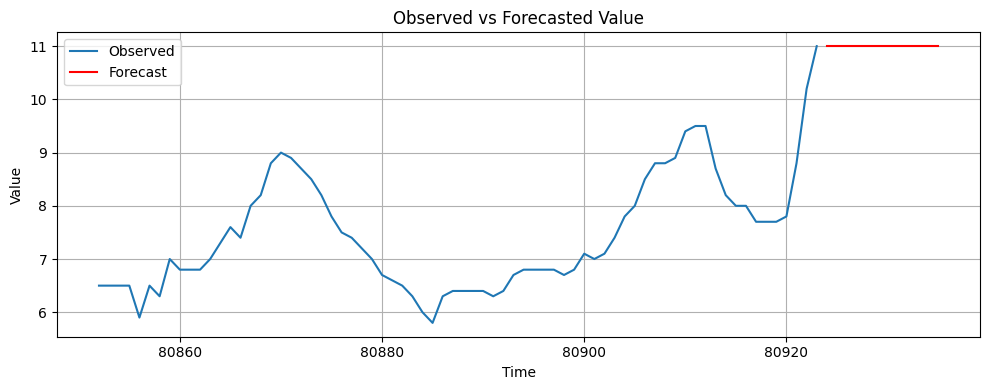

In [473]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Observed', linestyle="-")
plt.plot(y_pred_naive, label='Forecast', linestyle="-", color='red')
plt.title("Observed vs Forecasted Value")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### script to loop through all test data rows

In [477]:
from src.tuning.load_estimators import load_all_forecasters, get_estimator
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# This loads all sktime forecasters to be accessible by their class name -> don't need to run again
forecasters = load_all_forecasters()


def create_submission_file(
    patient_dfs, model, params={}, model_path = '', hrs_to_predict = 1, save_path="."
):  
    TIME_STEP_SIZE = (
        pd.to_datetime(row1["datetime"]).iloc[1] - pd.to_datetime(row1["datetime"]).iloc[0]
    ).components.minutes

    if TIME_STEP_SIZE != 5 and TIME_STEP_SIZE != 15:
        error = """
        First time step is not 5 or 15 minutes. Look at the most common time step size.
        """

    NUM_STEPS = hrs_to_predict * 60 // TIME_STEP_SIZE

    fh = np.arange(1, NUM_STEPS + 1)
    results = []


    for pid in tqdm(patient_dfs, desc="Patients"):
    # pid = 'p04'
    # fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
    # axes = axes.flatten()
    # subplot_idx = 0
    # legend_lines = []
    # legend_labels = []

        for row_id in tqdm(patient_dfs[pid], desc=f"Rows for {pid}", leave=False):
            df = patient_dfs[pid][row_id]
            try:

                if model == "TinyTimeMixerForecaster" :
                    forecaster = TinyTimeMixerForecaster(
                            model_path=model_path
                        )
                    forecaster.fit(y=y_train, X=X_train, fh=fh)
                else:
                    forecaster_class = get_estimator(forecasters, model)
                    forecaster = forecaster_class(**params)
                y, X = reduce_features(df)
                y.index += 80852
                X.index += 80852
                
                if model == "TinyTimeMixerForecaster" :
                    forecaster.update(y=y, X=X, update_params=False)
                else:
                    forecaster.fit(y=y, X=X, fh=fh)
                y_pred = forecaster.predict(fh=fh)

                predicted_value = y_pred.iloc[-1].item()

                results.append({"id": row_id, "bg+1:00": round(predicted_value, 2)})

                if False:
                    ######## Plot true glucose levels ########
                    ax = axes[subplot_idx]
                    observed_line = ax.plot(
                        # time_index[daystart : len(y) + daystart],
                        y["bg-0:00"],
                        color="skyblue",
                        label="True glucose levels",
                    )[0]
                    y_pred_ax = ax.plot(
                        # time_index[-72:],
                        y_pred,
                        color="darkorange",
                        linestyle="-",
                        label="Predicted glucose levels",
                    )[0]


                
                    ######## Plot predicted glucose levels ########
                    # Only store legend items from first subplot
                    if subplot_idx == 0:
                        legend_lines.extend([observed_line, y_pred_ax])
                        legend_labels.extend(
                            [
                                "True glucose levels",
                                "True nocturnal glucose levels",
                                "Predicted glucose levels",
                            ]
                        )

                    # Set limits to show full 24-hour period
                    # ax.set_xlim(time_index[0], time_index[-1])

                    # Add labels and formatting for each subplot (remove legend)
                    ax.set_xlabel("Time", fontsize=10)
                    # Hide y-axis labels for all plots except first in each row
                    if subplot_idx % 5 != 0:  # If not first plot in row
                        ax.yaxis.set_ticklabels([])
                    else:
                        ax.set_ylabel("BGL (mmol/L)", fontsize=10)
                    ax.set_ylim(0, 17.5)

                    ax.tick_params(axis="x", rotation=90, labelsize=8)
                    # Add horizontal reference lines
                    ax.axhline(
                        y=3.9, color="crimson", linestyle="--", alpha=0.5
                    )  # Hypoglycemia threshold
                    ax.axhline(
                        y=10.0, color="crimson", linestyle="--", alpha=0.5
                    )  # Hyperglycemia threshold

                    subplot_idx += 1



            except Exception as e:
                print(f"Failed to forecast {row_id} ({pid}): {e}")

    # fig.suptitle(
    #     f"Point Forecasting of Nocturnal Glucose Levels over 20 days \n {model} (after {epoch_num} epoch), Overall Nocturnal RMSE: {TOTAL_TEST_RMSE:.2f}",
    #     fontweight="bold",
    #     fontsize=16,
    # )

    # # Add a single legend outside the subplots
    # fig.legend(legend_lines, legend_labels, ncols=3, bbox_to_anchor=(0.65, 0.0))

    # # Adjust layout to avoid overlap with the legend
    # plt.tight_layout(rect=[0, 0, 0.95, 1], pad=2.0)

    # # Show the figure with multiple subplots
    # plt.show()

    # save to file
    results_df = pd.DataFrame(results)
    filename = f"{model}_submission.csv"

    os.makedirs(save_path, exist_ok=True)
    file_path = os.path.join(save_path, filename)

    results_df.to_csv(file_path, index=False)
    return results_df

In [478]:
# create_submission_file(
#     data,
#     "NaiveForecaster",
#     {"strategy": "last"},
#     save_path="../competition_submission",
# )

In [479]:
create_submission_file(
    data,
    "TinyTimeMixerForecaster",
    model_path = model_path,
    save_path="../competition_submission",
)

Patients:   0%|          | 0/15 [00:00<?, ?it/s]

Rows for p15:   0%|          | 0/294 [00:00<?, ?it/s]

Rows for p10:   0%|          | 0/179 [00:00<?, ?it/s]

Rows for p18:   0%|          | 0/231 [00:00<?, ?it/s]

Rows for p01:   0%|          | 0/244 [00:00<?, ?it/s]

Rows for p04:   0%|          | 0/258 [00:00<?, ?it/s]

Rows for p02:   0%|          | 0/227 [00:00<?, ?it/s]

Rows for p05:   0%|          | 0/276 [00:00<?, ?it/s]

Rows for p16:   0%|          | 0/248 [00:00<?, ?it/s]

Rows for p11:   0%|          | 0/221 [00:00<?, ?it/s]

Rows for p22:   0%|          | 0/201 [00:00<?, ?it/s]

Rows for p19:   0%|          | 0/246 [00:00<?, ?it/s]

Rows for p21:   0%|          | 0/236 [00:00<?, ?it/s]

Rows for p24:   0%|          | 0/261 [00:00<?, ?it/s]

Rows for p06:   0%|          | 0/234 [00:00<?, ?it/s]

Rows for p12:   0%|          | 0/288 [00:00<?, ?it/s]

,id,bg+1:00
0,p15_218,5.83
1,p15_256,7.50
2,p15_275,8.31
3,p15_252,7.39
4,p15_128,7.10
...,...,...
3639,p12_25348,11.87
3640,p12_25467,7.30
3641,p12_25310,8.64
3642,p12_25393,8.73
